# Maximum Likelihood Estimation Linear Regression

Useful Sources:
   * http://jekel.me/2016/Maximum-Likelihood-Linear-Regression/
   * http://suriyadeepan.github.io/2017-01-22-mle-linear-regression/
   * http://dfm.io/emcee/current/user/line/
   * https://arxiv.org/pdf/1008.4686.pdf
   Data analysis recipes: Fitting a model to data∗  
      David W. Hogg, Jo Bovy, Dustin Lang (2010)
        Equations 9-11

In [1]:
from __future__ import division
from scipy.optimize import minimize
import pandas as pd
from math import pi
import numpy as np
from numpy import std, exp, log, log10

from Zoldak.Math.loggingdata import log_margin_of_error

import matplotlib.pyplot as plt
%matplotlib inline

### Log-Likelihood function and Linear Model to minimize.

The scipy.optimize module minimizes functions.
We want to maximize the likelihood function. 
To maximize the likelihood, you minimize the negative log likelihood:
    
    Maximum Likelihood = -1 * loglikelihood 

In [2]:
def LogLikelihood(estimate, true, n, sigma):
    '''
    LogLikelihood(estimate, true, n, sigma)
   
    The scipy.optimize.minimize module minimizes functions.
    We want to maximize the likelihood function. 
    To maximize the likelihood, you minimize the negative log-likelihood,
    hence the -1 * LogLikelihood.
    
    This is the LogLikelihood that can then be multiplied by -1 and minimized.
    

    
    PARAMETERS:
    ----------
    
    estimate: float, is the estimate for y based on the model. 
    true:     float, is the y-data value. 
    n:        float, length of the estimate. 
    sigma:    float, scatter about the relation. 
    
    if you don't want sigma to be a free parameter, use
        sigma = np.std(error) 
    and remove it from parameters assignment. 
    
    RETURNS:
    ----------
    returns the log-likelihood. 
    
    
    NOTES:
    ----------
    The error is the true - estimate, or ydata - ymodel. These are also known 
    as the residuals of the fit; the distances between the actual data point 
    along the y-axis and the model. Errors/residuals are along y-axis only
    meaning they are the vertical offsets and not perpendicular offsets. 
    Vertical offsets are the most common in linear regression. 
    
    '''
    error = true - estimate       # ydata - yModel, aka residual
    L = (-0.5*n*log(2.0*pi*sigma*sigma)) - (sum(error**2)/(2.0*sigma*sigma))
    return L
    
def linear_model(parameters, x, y):
    '''
    linear_model(parameters, x, y)
    -- Linear model. 
    
    PARAMETERS:
    ----------
    parameters: list, [m, b, sigma], where m and b are the slope and y-intercept
                and sigma is the scatter about the lienar relation. 
    x:          list or array of xdata. **
    y:          list or array of ydata. **
    
    ** - pandas dataframe Series work as well. 
    
    RETURNS:
    ----------
    returns -1 * Log-Likelihood, where the yModel is a line. 
    
        
    '''
    m,b,sigma = parameters   # m:slope, b:yintercept
    yModel    = m * x + b    # estimate of y based on model. 
    return (-1 * LogLikelihood(yModel, y, len(yModel), sigma) ) # -1 * loglike

### READ IN DATA

In [3]:
df  = pd.read_csv('/Users/KimiZ/GRBs2/Sample/AmatiDataSample.txt', sep=',', header=0)
df.head()

,name,z,eiso,eiso_err_low,eiso_err_up,epeak,epeak_err_low,epeak_err_up,epeakRest,epeakRest_err_low,epeakRest_err_up
0,970228,0.695,1.649150e+52,1.241290e+51,1.241290e+51,115.044248,37.758112,37.758112,195.0,64.0,64.0
1,970508,0.835,6.321990e+51,1.335630e+51,1.335630e+51,79.019074,23.433243,23.433243,145.0,43.0,43.0
2,970828,0.958,3.037590e+53,3.573640e+52,3.573640e+52,299.284985,59.754852,59.754852,586.0,117.0,117.0
3,971214,3.420,2.205530e+53,2.756910e+52,2.756910e+52,154.977376,30.090498,30.090498,685.0,133.0,133.0
4,980326,1.000,5.008430e+51,9.837990e+50,9.837990e+50,35.500000,18.000000,18.000000,71.0,36.0,36.0


In [4]:
# log_margin_of_error(value, moe_lower, moe_upper)
# Logging our Data to make it easier to handle. Apply an offset for eiso data.

xoffset = 1.0E52
xdata,xerrL,xerrU = log_margin_of_error(df.eiso/xoffset, 
                                        df.eiso_err_low/xoffset, 
                                        df.eiso_err_up/xoffset)

ydata,yerrL,yerrU = log_margin_of_error(df.epeakRest, 
                                        df.epeakRest_err_low, 
                                        df.epeakRest_err_up)

In [5]:
# run the calculations
result = minimize( fun     = linear_model,       # function to minimize (linear model)
                   x0      = np.array([1,1,1]),  # initial guess for all parameters. 
                   method  = 'L-BFGS-B',         # method of solver. 
                   args    = (xdata, ydata))     # extra arguments to pass to the function. 
                                                 # Ours are x an y values.  

result

      fun: -14.637374487584538
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00030695,  0.00020606,  0.00014779])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 108
      nit: 15
   status: 0
  success: True
        x: array([ 0.52089852,  2.05148981,  0.21989446])

In [6]:
m_ml, b_ml, s_ml = result.x  # slope, yintercept, scatter

In [7]:
line = lambda x,m,b: m * x + b

## Plot

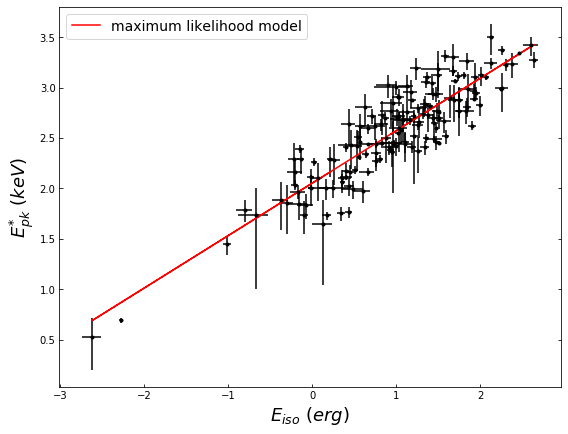

In [8]:
# plot data
plt.figure(figsize=(9,7))
plt.errorbar(x = xdata, y = ydata,
             xerr = [xerrL, xerrU],
             yerr = [yerrL, yerrU],
             fmt='k.')
# plot model
ymodel = lambda m,x,b: m*x+b
plt.plot(xdata, line(xdata, m_ml, b_ml), 'r-', label='maximum likelihood model')

plt.ylabel('$E^{*}_{pk}$ ($keV$)', fontsize=18)
plt.xlabel('$E_{iso}$ ($erg$)', fontsize=18)
plt.legend(loc='best', numpoints=1, fontsize=14)
plt.show()

# To Continue, see mle_linear_regression_w_MCMC_errors.ipynb